In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


# Промышленные продажи бумаги для печати и письма (1963 – 1972)
## Industry sales for printing and writing paper (Jan 63 – Dec 1972)

## 1. Загрузка данных

In [2]:
paper_sales_data = pd.read_csv('industry-sales-for-printing-and-.csv', ';', index_col=['Month'], parse_dates=['Month'])
paper_sales_data.columns = ['sales']
paper_sales_data = paper_sales_data.drop(paper_sales_data.index[len(paper_sales_data)-1])

In [3]:
paper_sales_data.describe()

,sales
count,120.000000
mean,713.749200
std,174.050535
min,215.187000
25%,633.284000
50%,733.300000
75%,833.147000
max,1006.852000


In [4]:
print('Количество отсчётов больше 100?: ', len(paper_sales_data) > 100)

Количество отсчётов больше 100?:  True


## 1.2 Визуализация загруженных данных 

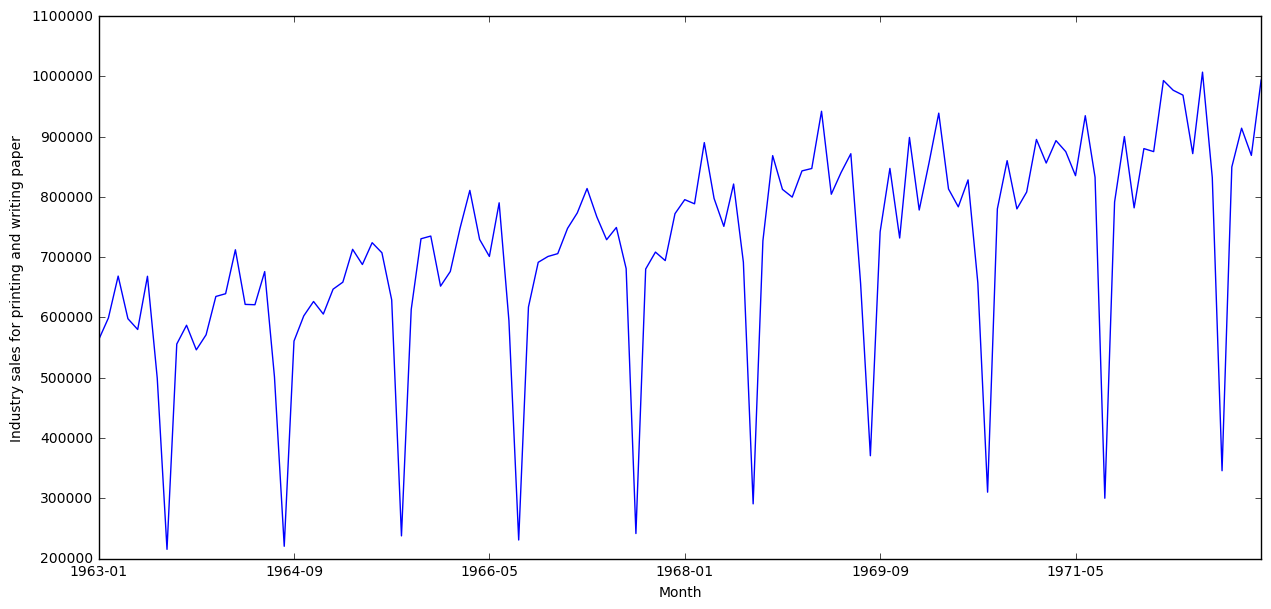

In [5]:
paper_sales_data.sales = paper_sales_data.sales * 1000 # values in 1000
plt.figure(figsize(15,7))
paper_sales_data.sales.plot()
plt.ylabel('Industry sales for printing and writing paper')
pylab.show()

## 2. Анализ и обработка ряда

## 2.1 Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.942338


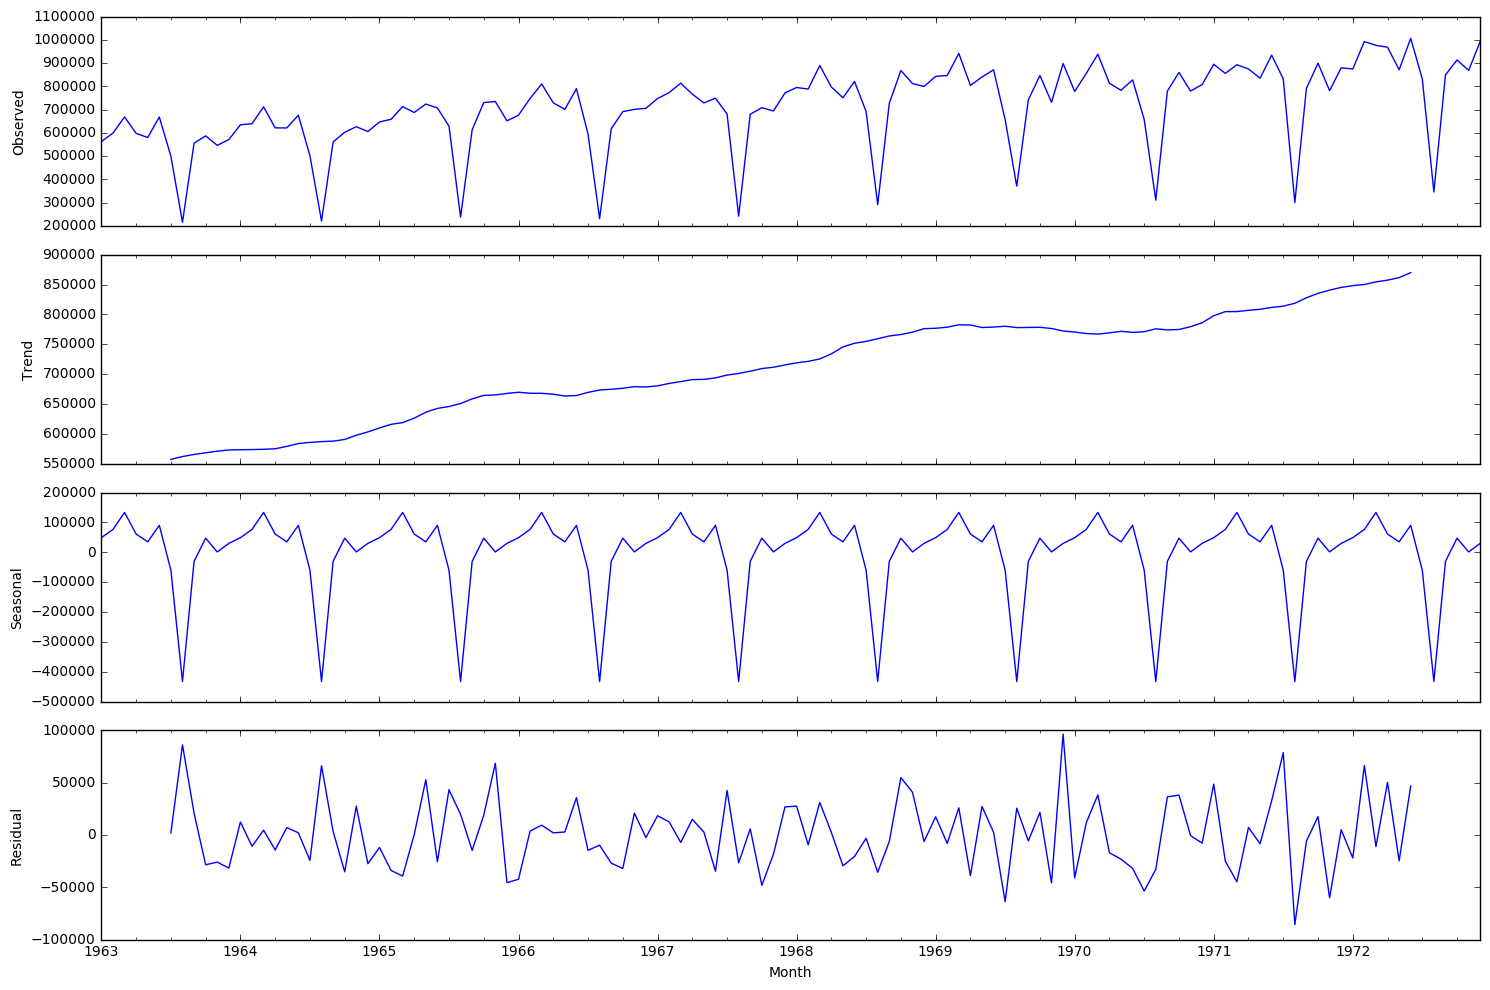

In [6]:
plt.figure(figsize(15,10))
paper_sales_data.reset_index(inplace=True)
paper_sales_data['Month'] = pd.to_datetime(paper_sales_data['Month'])
paper_sales_data = paper_sales_data.set_index('Month')
sm.tsa.seasonal_decompose(paper_sales_data.sales).plot()
print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(paper_sales_data.sales)[1])

Так как значение критерия Дики-Фуллера достаточно большое, и, сама нестанционарность ряда заметна визуально ряд может быть классифицирован как нестанционарный. Дисперсия же, в свою очередь, не выглядит очень стабильной, поэтому применим методы стабилизации для ее нормализации, а именно применим приобразования Бокса-Кокса. 

## 2.2 Стабилизация дисперсии преобразованием Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 2.193636
Критерий Дики-Фуллера: p=0.993612


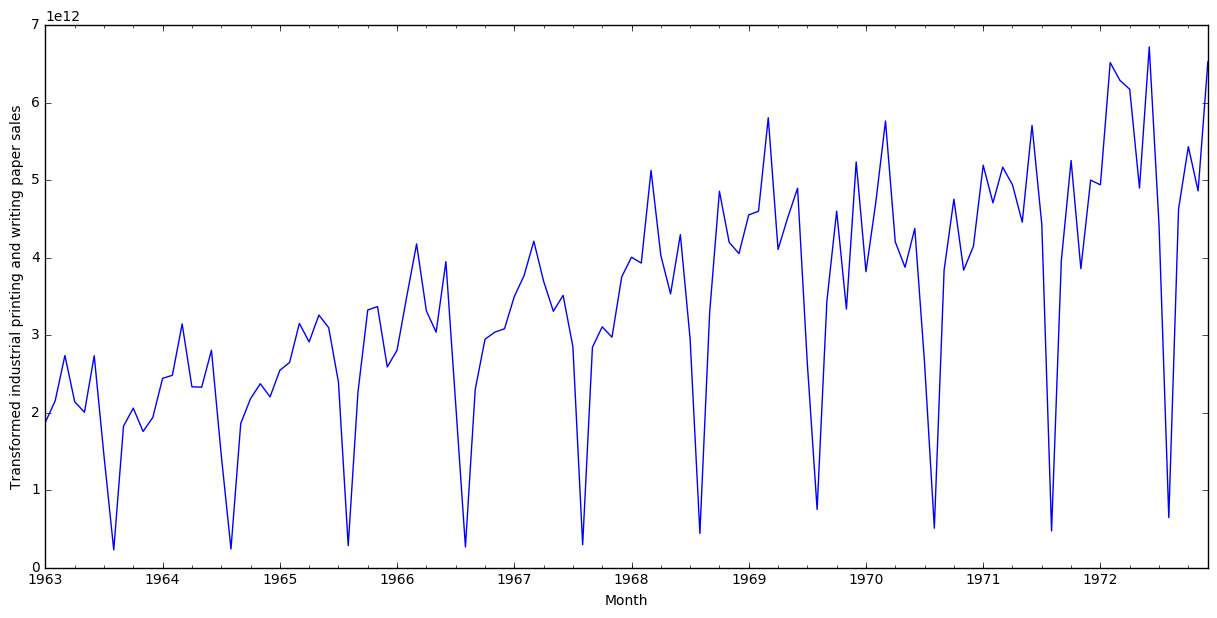

In [7]:
paper_sales_data['sales_box'], lmbda = stats.boxcox(paper_sales_data.sales)
plt.figure(figsize(15,7))
paper_sales_data.sales_box.plot()
plt.ylabel(u'Transformed industrial printing and writing paper sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(paper_sales_data.sales_box)[1])

## 2.3 Сезонное и обычное дифференцирование для повышение станционарности

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.116409


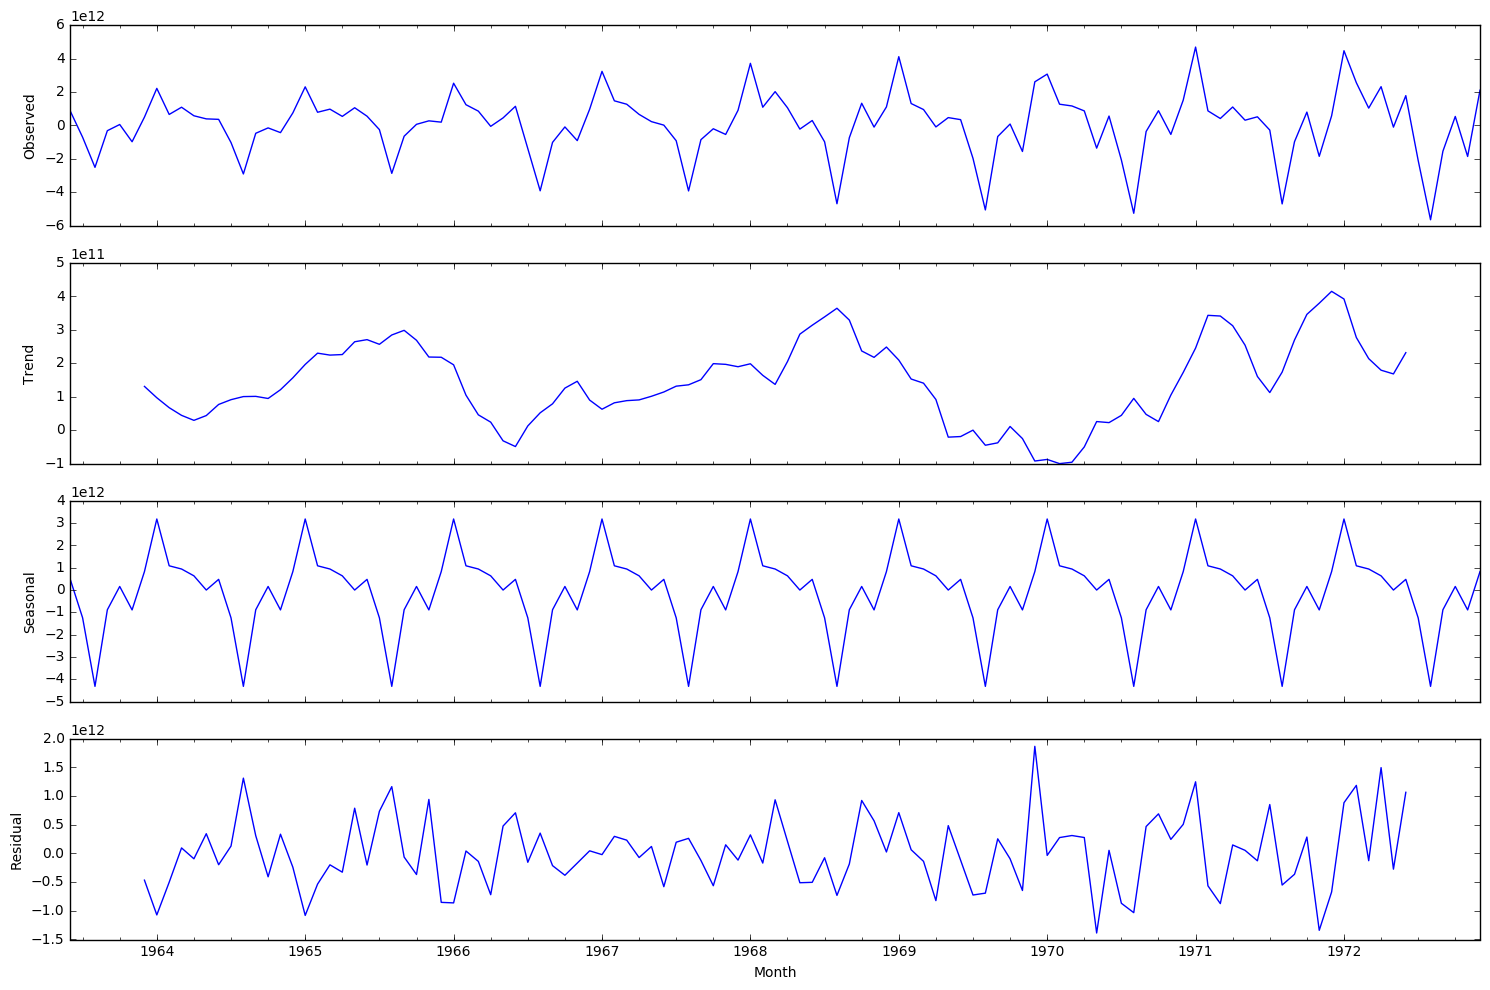

In [8]:
paper_sales_data['sales_box_diff'] = paper_sales_data.sales_box - paper_sales_data.sales_box.shift(5)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(paper_sales_data.sales_box_diff[5:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(paper_sales_data.sales_box_diff[5:])[1])

Критерий Дики-Фуллера уже меньше 0.01, и отвергает гипотезу нестационарности, однако, полностью избавиться от тренда не удалось.
Поэтому, пропробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


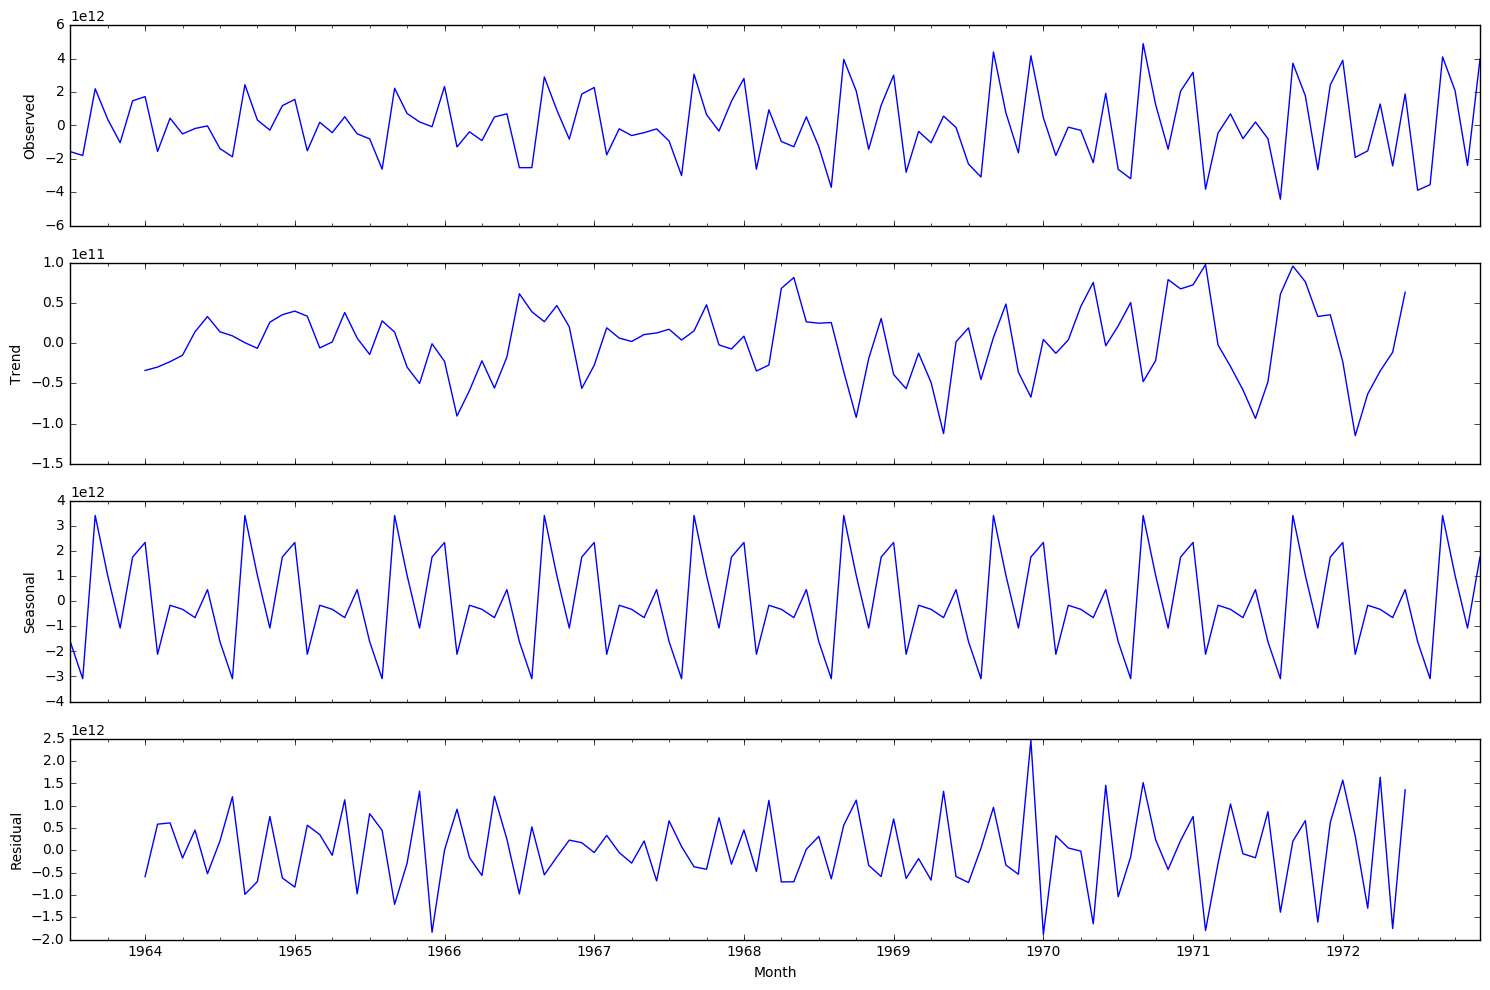

In [9]:
paper_sales_data['sales_box_diff2'] = paper_sales_data.sales_box_diff - paper_sales_data.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(paper_sales_data.sales_box_diff2[6:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(paper_sales_data.sales_box_diff2[6:])[1])

Критерий Дики-Филлера стал еще меньше, подтверждая отвергая тем самым гипотезу о нестационарности.А также ряд избавился от сезонности. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

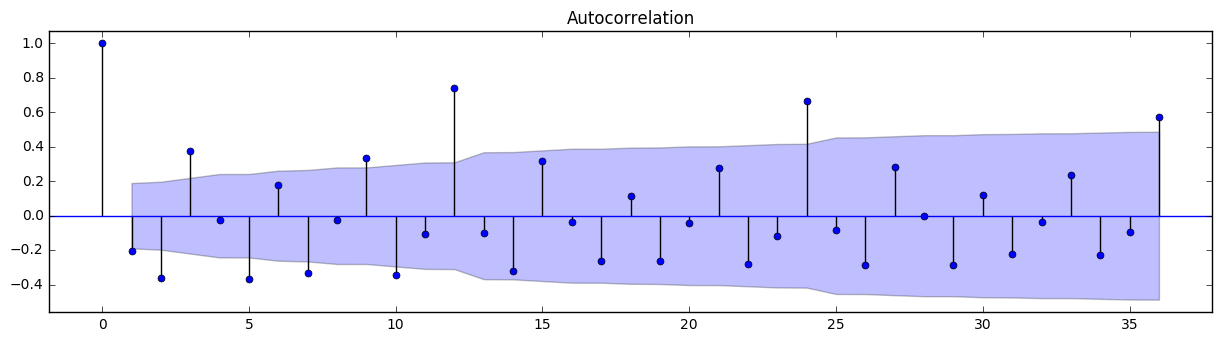

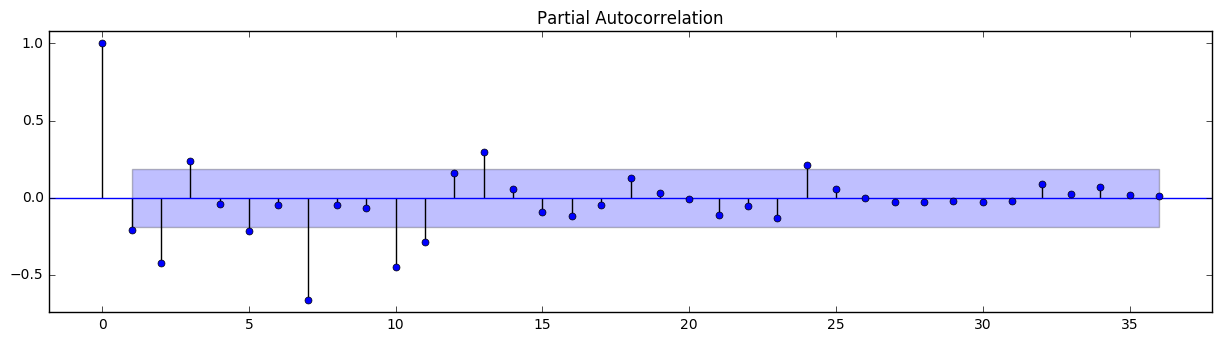

In [10]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(paper_sales_data.sales_box_diff2[13:].values.squeeze(), lags=36, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(paper_sales_data.sales_box_diff2[13:].values.squeeze(), lags=36, ax=ax)
pylab.show()

Начальные приближения:
* d = 1 - одно сезонное дифференцирование
* D = 1 - одно обычное дифференцирование
* p = 4 - номер последнего несезонного лага, при котором частичная автокорреляция значима (PACF)
* P = 1 - номер последнего сезонного лага, при котором частичная автокорреляция значима (PACF)
* q = 4 - номер последнего несезонного лага, при котором частичная автокорреляция значима (ACF)
* Q = 1 - номер последнего сезонного лага, при котором частичная автокорреляция значима (ACF)

In [11]:
ps = range(0, 5)
d=1
qs = range(3, 5)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [12]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

20

In [13]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(paper_sales_data.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (2, 4, 0, 0)
wrong parameters: (2, 4, 1, 0)
wrong parameters: (3, 4, 0, 0)
wrong parameters: (3, 4, 1, 0)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 3, 1, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 1, 0)
CPU times: user 12.4 s, sys: 300 ms, total: 12.7 s
Wall time: 10.4 s


In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters          aic
1  (0, 3, 1, 0)  6092.483879
5  (1, 3, 1, 0)  6093.310520
3  (0, 4, 1, 0)  6094.131275
9  (2, 3, 1, 0)  6094.448319
7  (1, 4, 1, 0)  6095.051369


Лучшая модель:

In [15]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  120
Model:             SARIMAX(0, 1, 3)x(1, 1, 0, 12)   Log Likelihood               -3041.242
Date:                            Tue, 20 Dec 2016   AIC                           6092.484
Time:                                    19:50:10   BIC                           6106.421
Sample:                                01-01-1963   HQIC                          6098.144
                                     - 12-01-1972                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7300      0.110     -6.661      0.000      -0.945      -0.515
ma.L2         -0.0016      0.150   

Её остатки:

Критерий Стьюдента: p=0.611705
Критерий Дики-Фуллера: p=0.000000


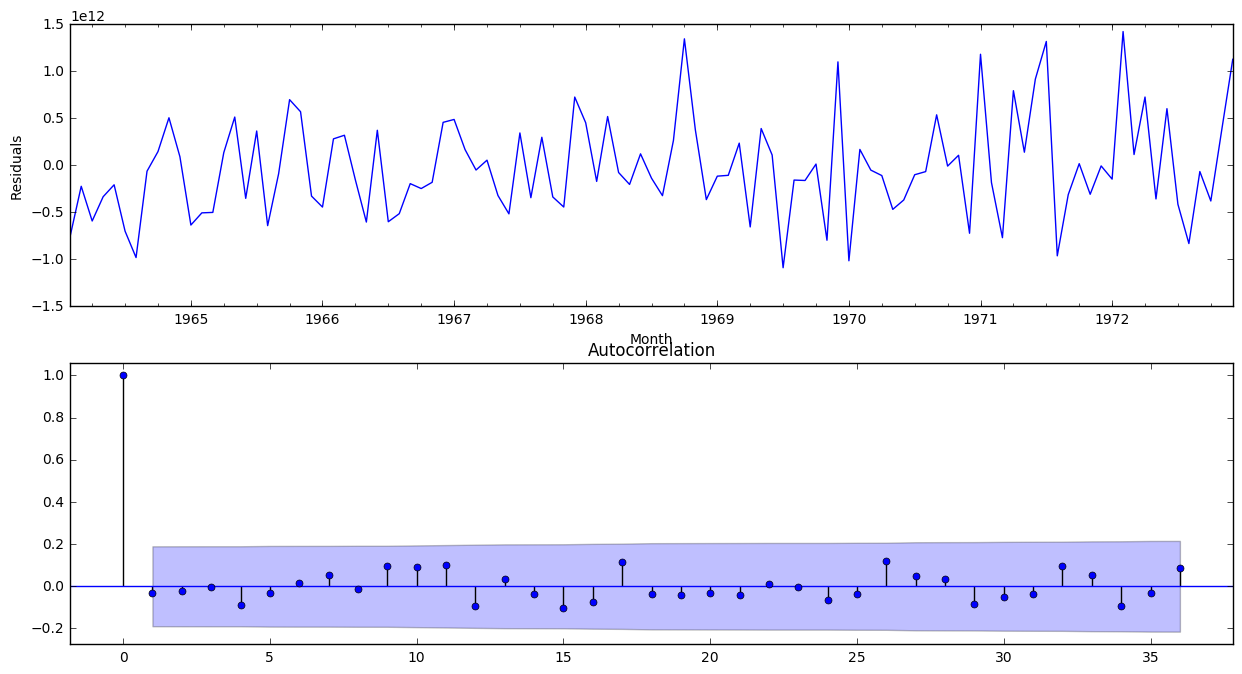

In [16]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=36, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [17]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

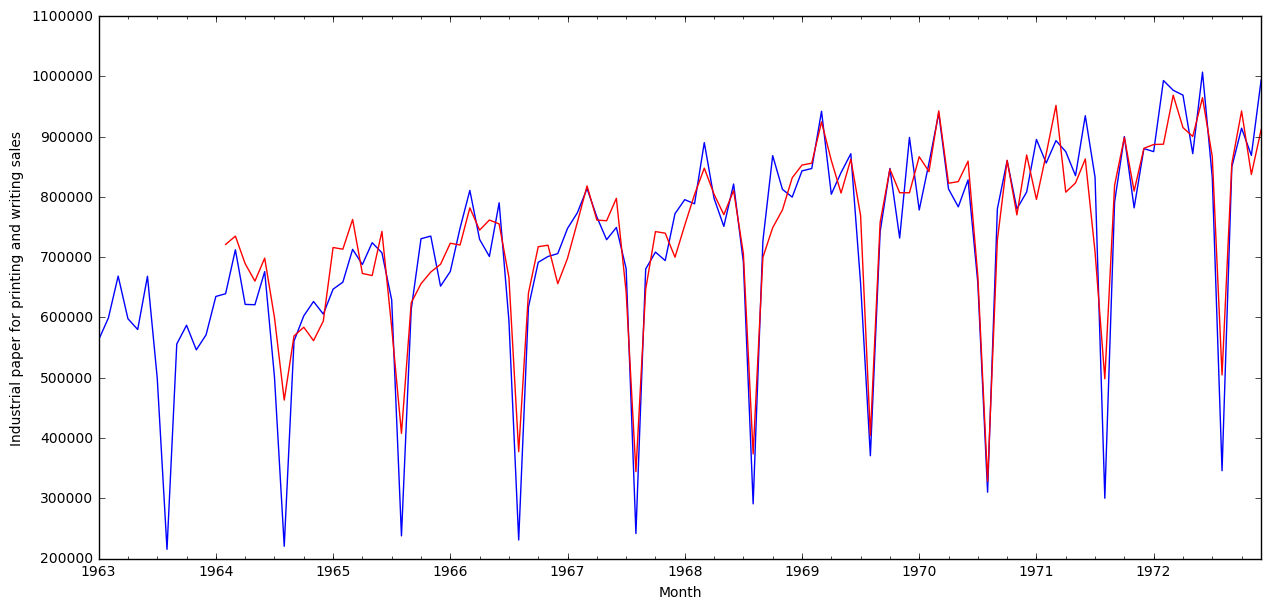

In [18]:
paper_sales_data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
paper_sales_data.sales.plot()
paper_sales_data.model[13:].plot(color='r')
plt.ylabel('Industrial paper for printing and writing sales')
pylab.show()

### Прогноз

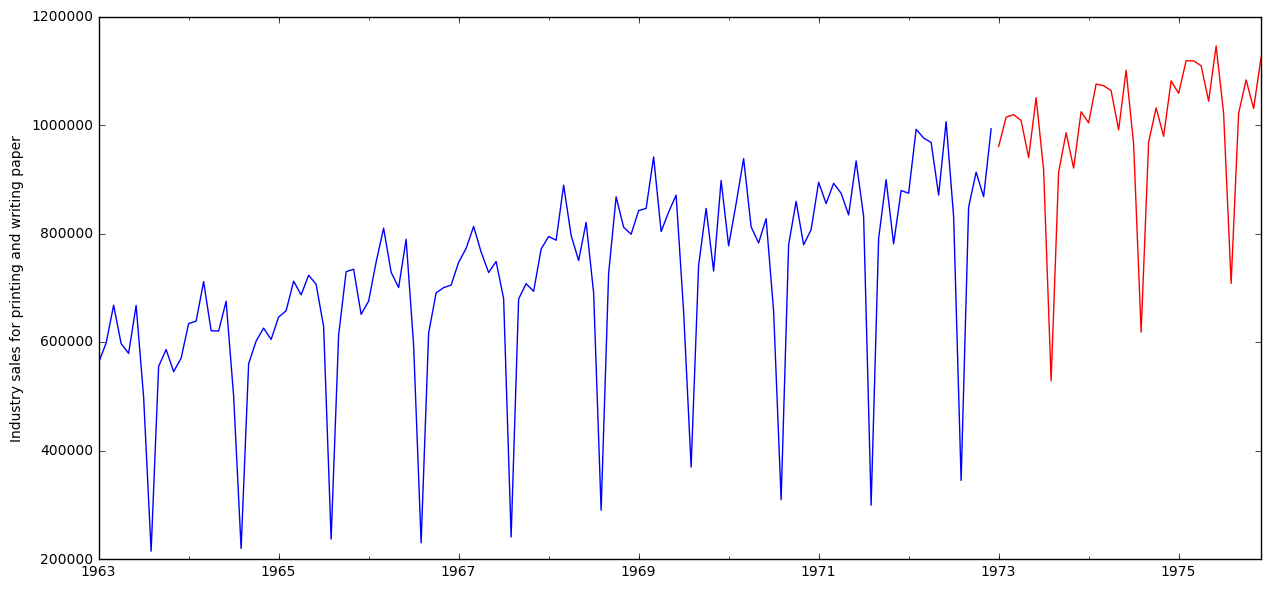

In [19]:
paper_sales_data2 = paper_sales_data[['sales']]
date_list = [datetime.datetime.strptime("1973-01", "%Y-%m") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= paper_sales_data2.columns)
paper_sales_data2 = pd.concat([paper_sales_data2, future])
paper_sales_data2['forecast'] = invboxcox(best_model.predict(start=120, end=156), lmbda)

plt.figure(figsize(15,7))
paper_sales_data2.sales.plot()
paper_sales_data2.forecast.plot(color='r')
plt.ylabel('Industry sales for printing and writing paper')
pylab.show()